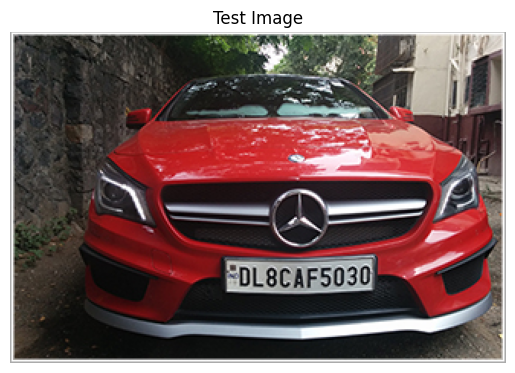

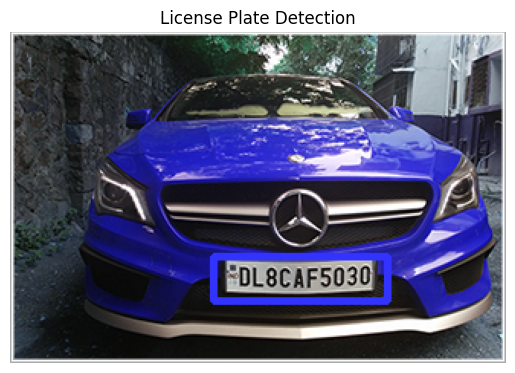

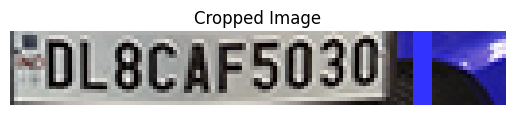

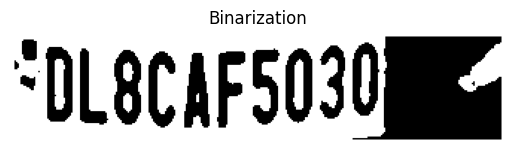

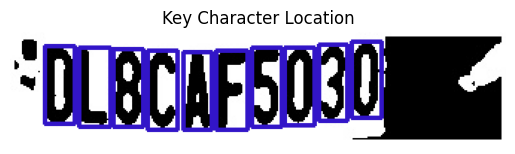

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
CNN- CHARACTER RECOGNITION


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │          55,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 862,916 (3.29 MB)

 Trainable params: 862,916 (3.29 MB)

 Non-trainable params: 0 (0.00 B)

Character segmentation
10


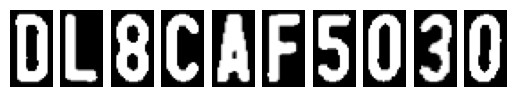

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.axis("off")
    plt.title("Key Character Location")
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.axis("off")
    plt.title("Binarization")
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

img = cv2.imread('car.jpg')
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(image)
plt.title("Test Image")
plt.show()
plate_img = img.copy()


from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')
plate_rect1 = plate_cascade.detectMultiScale(image, scaleFactor = 1.3, minNeighbors = 7)
x = plate_rect1[0,0]
y = plate_rect1[0,1]
w = plate_rect1[0,2]
h = plate_rect1[0,3]

a,b = (int(0.025*img.shape[0]), int(0.025*img.shape[1]))
cv2.rectangle(plate_img, (x,y), (x+w,y+h), (51,51,255), 3)
plt.axis("off")
plt.title("License Plate Detection")
plt.imshow(plate_img)
plt.show()

plate = plate_img[y+a:y+h-a, x+b:x+w-b+30]
plt.axis("off")
plt.title("Cropped Image")
plt.imshow(plate)
plt.show()

embedding_vector_features = 45
char = segment_characters(plate)

import zipfile
import os
import shutil
with zipfile.ZipFile('data.zip', 'r') as f:
  f.extractall('.')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'data/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

model = Sequential()
model.add(Conv2D(32,(24,24),input_shape=(28,28,3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))
print("CNN- CHARACTER RECOGNITION")
model.summary()


batch_size = 1
print("Character segmentation")
print(len(char))
flen = len(char)

for i in range(flen):
  plt.subplot(1, flen, i+1)
  plt.imshow(char[i], cmap='gray')
  plt.axis('off')
plt.show()



In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Image Data Generator for real-time data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Loading the dataset
train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(28, 28),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=(28, 28),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale'
)

# Define the CNN model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output and pass it through fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 36 nodes (26 letters + 10 digits) and softmax activation
model.add(Dense(36, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=70,  # You can increase the number of epochs
    validation_data=validation_generator
)

# Save the trained model to seg-CNN.h5
model.save('seg-CNN.h5')
print("Model saved as seg-CNN.h5")


Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,828 (444.64 KB)

 Trainable params: 113,828 (444.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.0442 - loss: 3.5748 - val_accuracy: 0.0833 - val_loss: 3.4998
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0807 - loss: 3.4759 - val_accuracy: 0.1806 - val_loss: 3.0525
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.1325 - loss: 3.0555 - val_accuracy: 0.3009 - val_loss: 2.3248
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2036 - loss: 2.6345 - val_accuracy: 0.5324 - val_loss: 1.7763
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3278 - loss: 2.1893 - val_accuracy: 0.6435 - val_loss: 1.3243
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.3926 - loss: 1.9382 - val_accuracy: 0.7315 - val_loss: 1.0521
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4513 - loss: 1.6563 - val_accuracy: 0.7407 - val_loss: 0.9037
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5168 - loss: 1.4043 - val_accuracy: 0.7037 - val_loss: 0.

Model saved as seg-CNN.h5


Character Recognized
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
0L8DAF5030
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━

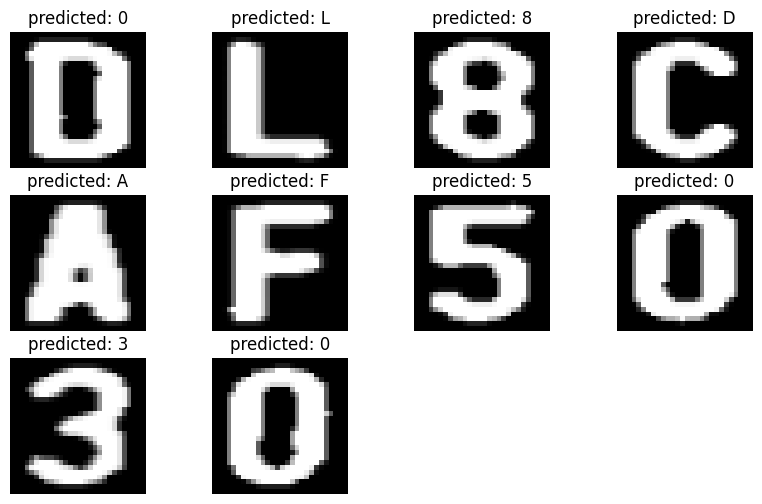

In [3]:
import tensorflow as tf
model = tf.keras.models.load_model('seg-CNN.h5')
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Predicting the output
# Removed fix_dimension function, as we want to predict on grayscale images

def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        # The image is already grayscale; no need to convert.
        # img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
        img = img_.reshape(1,28,28,1) #preparing image for the model - Reshaped to (1, 28, 28, 1) for grayscale
        # Instead of predict_classes, use predict and np.argmax
        y_ = np.argmax(model.predict(img), axis=-1)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list

    plate_number = ''.join(output)

    return plate_number
print("Character Recognized")
print(show_results())
plt.figure(figsize=(flen,6))


for i,ch in enumerate(char):
  img = cv2.resize(ch, (28,28))
  plt.subplot(3,4,i+1)
  plt.imshow(img, cmap='gray')
  plt.title(f'predicted: {show_results()[i]}')
  plt.axis('off')
plt.show()
